In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from collections import Counter
from mpl_toolkits.mplot3d import Axes3D

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [46]:
data = pd.read_csv('/content/drive/MyDrive/Redes Neuronales/alturas-pesos-mils-train.csv')
#len(data)

In [47]:
test = pd.read_csv('/content/drive/MyDrive/Redes Neuronales/alturas-pesos-mils-test.csv')
#test

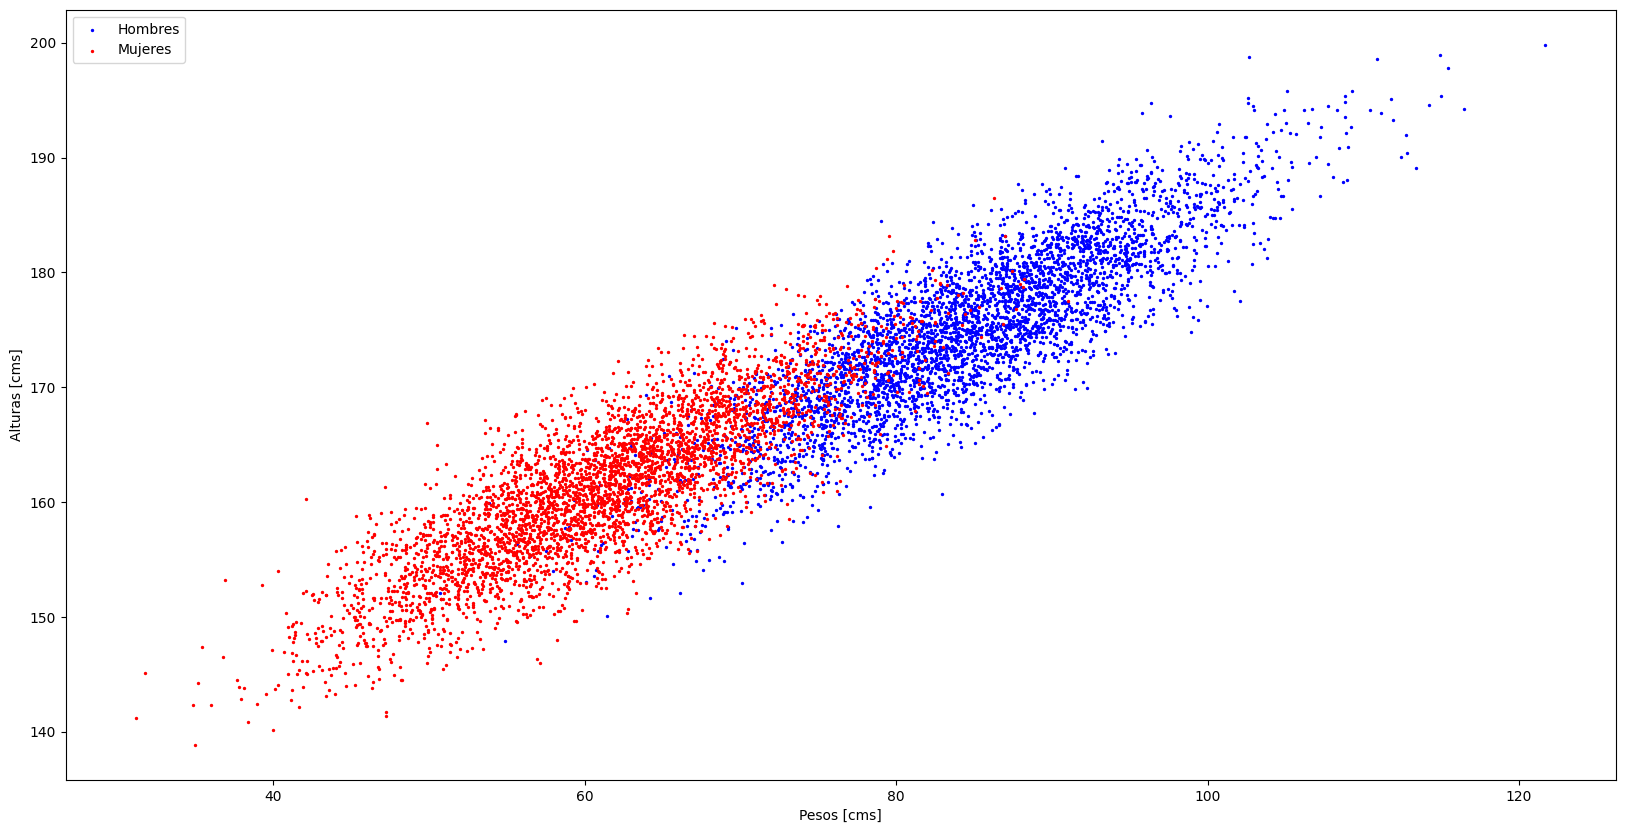

In [48]:
data_hombres = data.loc[data['Genero']=='Hombre'][['Peso','Altura']].values
data_mujeres = data.loc[data['Genero']=='Mujer'][['Peso','Altura']].values
acc = data['Genero'].map({'Hombre': 0, 'Mujer': 1}).values
acc_test = test['Genero'].map({'Hombre': 0, 'Mujer': 1}).values


f = plt.figure(figsize=(20,10))
plt.scatter(data_hombres[:,0], data_hombres[:,1], color='b', s=2, label='Hombres')
plt.scatter(data_mujeres[:,0], data_mujeres[:,1], color='r', s=2, label='Mujeres')
plt.xlabel('Pesos [cms]')
plt.ylabel('Alturas [cms]')
plt.legend()
plt.show()
#data_hombres

In [63]:
mean_h = np.mean(data_hombres, axis=0)
mean_m = np.mean(data_mujeres, axis=0)
#print(mean_h)
#print(mean_m)

cov_h = np.cov(data_hombres.T)
cov_m = np.cov(data_mujeres.T)
#print(cov_h)

cov_LDA = (cov_h + cov_m) / 2
cov_inv = np.linalg.inv(cov_LDA)
#print(cov_LDA)

[[77.94673397 53.5300495 ]
 [53.5300495  50.29651005]]


In [53]:
prob_h = len(data_hombres) / len(data)
prob_m = len(data_mujeres) / len(data)
data_train = data[['Peso', 'Altura']].values

predictions_train = []
for x in data_train:
  score_hombres = np.dot(x, np.dot(cov_inv, mean_h)) -0.5 * np.dot(mean_h, np.dot(cov_inv, mean_h)) + np.log(prob_h)
  score_mujeres = np.dot(x, np.dot(cov_inv, mean_m)) -0.5 * np.dot(mean_m, np.dot(cov_inv, mean_m)) + np.log(prob_m)

  if score_hombres > score_mujeres:
    predictions_train.append(0)  # Hombre
  else:
    predictions_train.append(1)  # Mujer


train_acc = 0
for i in range(len(predictions_train)):
  if predictions_train[i] == acc[i]:
   train_acc += 1

train_acc = train_acc / len(predictions_train)

In [68]:
data_test = test[['Peso', 'Altura']].values

predictions_test = []
for x in data_test:
  score_hombres = np.dot(x, np.dot(cov_inv, mean_h)) -0.5 * np.dot(mean_h, np.dot(cov_inv, mean_h)) + np.log(prob_h)
  score_mujeres = np.dot(x, np.dot(cov_inv, mean_m)) -0.5 * np.dot(mean_m, np.dot(cov_inv, mean_m)) + np.log(prob_m)

  if score_hombres > score_mujeres:
    predictions_test.append(0)  # Hombre
  else:
    predictions_test.append(1)  # Mujer

test_acc = 0
for i in range(len(predictions_test)):
  if predictions_test[i] == acc_test[i]:
   test_acc += 1

test_acc = test_acc / len(predictions_test)
print(f'Accuracy LDA para train: {train_acc * 100:.2f}%')
print(f'Accuracy LDA para test: {test_acc * 100:.2f}%')

Accuracy LDA para train: 91.67%
Accuracy LDA para test: 92.25%


In [66]:
from scipy.stats import multivariate_normal

def get_gauss_prob(data, mean_hombres, mean_mujeres, cov_hombres, cov_mujeres):
    data_np = data
    likelihood_class_1 = multivariate_normal.pdf(data_np, mean_hombres, cov_hombres)
    likelihood_class_2 = multivariate_normal.pdf(data_np, mean_mujeres, cov_mujeres)
    N_class_1 = len(data_hombres)
    N_class_2 = len(data_mujeres)
    prior_1 = N_class_1/(N_class_1 + N_class_2)
    prior_2 = N_class_2/(N_class_1 + N_class_2)
    total = likelihood_class_1 * prior_1 + likelihood_class_2 * prior_2
    p_class_1 = likelihood_class_1 * prior_1/total
    p_class_2 = likelihood_class_2 * prior_2/total
    return p_class_1, p_class_2

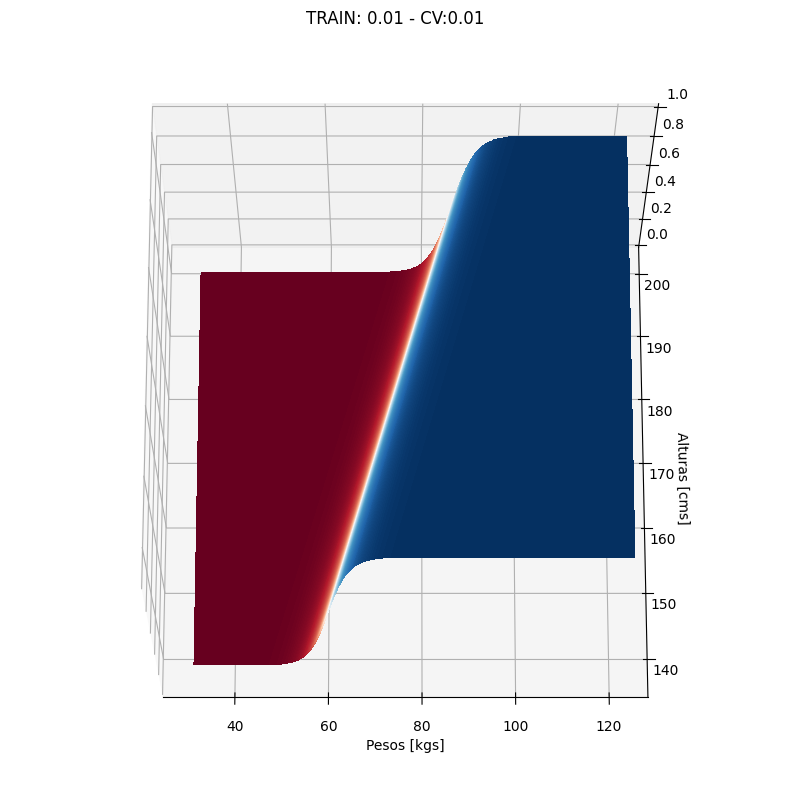

In [67]:
N = 300
X = np.linspace(data.min()['Peso'], data.max()['Peso'], N)
Y = np.linspace(data.min()['Altura'], data.max()['Altura'], N)

# Create a meshgrid from X and Y
X, Y = np.meshgrid(X, Y)

# Reshape the meshgrid to a format suitable for get_gauss_prob
pos = np.dstack((X, Y))


Z_LDA, _ = get_gauss_prob(pos, mean_h, mean_m, cov_LDA, cov_LDA)

# Create a figure and a 3D subplot using plt.subplots
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={'projection': '3d'})

# The rest of the plotting code:
cm = plt.cm.RdBu
ax.contourf(X, Y, Z_LDA, 256, vmin=0., vmax=1., cmap=cm)
ax.set_title('TRAIN: ' + str(np.round(train_acc)/100) + ' - CV:' + str(np.round(test_acc)/100))
ax.set_ylabel('Alturas [cms]')
ax.set_xlabel('Pesos [kgs]')
ax.view_init(70, -90)
plt.show()

In [ ]:
#Parametros manuales
w = np.dot(cov_inv, (mean_h - mean_m))
b = -0.5 * np.dot(mean_h, np.dot(cov_inv, mean_h)) + \
    0.5 * np.dot(mean_m, np.dot(cov_inv, mean_m)) + np.log(prob_h / prob_m)

In [72]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score

X = data[["Altura", "Peso"]].values
y = data["Genero"].values

lda_sklearn = LinearDiscriminantAnalysis()
lda_sklearn.fit(X, y)


y_pred_sklearn = lda_sklearn.predict(X)

accuracy_sklearn = accuracy_score(y, y_pred_sklearn)
print(f"Precisión del modelo LDA con sklearn: {accuracy_sklearn*100}")

Precisión del modelo LDA con sklearn: 91.675


In [74]:
X_t = test[["Altura", "Peso"]].values
y_t = test["Genero"].values

lda_sklearn = LinearDiscriminantAnalysis()
lda_sklearn.fit(X_t, y_t)


y_test_sklearn = lda_sklearn.predict(X_t)

accuracy_sklearn = accuracy_score(y_t, y_test_sklearn)
print(f"Precisión del modelo LDA con sklearn en test: {accuracy_sklearn*100}")

Precisión del modelo LDA con sklearn en test: 92.4


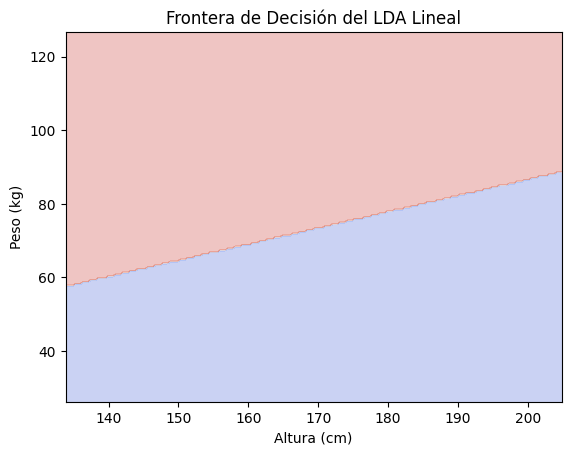

In [96]:
# Crear una malla de valores para Altura y Peso
x_min, x_max = data["Altura"].min() - 5, data["Altura"].max() + 5
y_min, y_max = data["Peso"].min() - 5, data["Peso"].max() + 5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))

# Aplanar la malla y predecir con el modelo LDA entrenado
X_grid = np.c_[xx.ravel(), yy.ravel()]  # Solo usamos Altura y Peso
Z = lda_sklearn.predict(X_grid)
# Convert string predictions to numerical values
Z = [1 if z == 'Hombre' else 0 for z in Z] # Assuming 'Hombre' is 0 and 'Mujer' is 1. Adjust if needed
Z = np.array(Z).reshape(xx.shape)

# Graficar la frontera de decisión
plt.contourf(xx, yy, Z, alpha=0.3, cmap="coolwarm")
plt.xlabel("Altura (cm)")
plt.ylabel("Peso (kg)")
plt.title("Frontera de Decisión del LDA Lineal")
plt.show()

In [75]:
# Coeficientes y sesgo del modelo de sklearn
w_sklearn = lda_sklearn.coef_[0]
b_sklearn = lda_sklearn.intercept_[0]

print(f"Coeficientes obtenidos manualmente: {w}")
print(f"Coeficientes obtenidos con sklearn: {w_sklearn}")
print(f"Intercepto obtenido manualmente: {b}")
print(f"Intercepto obtenido con sklearn: {b_sklearn}")

Coeficientes obtenidos manualmente: [ 0.42106101 -0.17752323]
Coeficientes obtenidos con sklearn: [ 0.18837243 -0.42829467]
Intercepto obtenido manualmente: -0.8073957110256953
Intercepto obtenido con sklearn: -0.5828948560572087


Aunque los modelos tienen una accuracy muy similar, sus coeficientes aparecen invertidos. Es decir que tienen diferentes umbrales de decision con resultados similares.

In [78]:
data["Peso^2"] = data["Peso"] ** 2
data["Altura^2"] = data["Altura"] ** 2
data["Peso*Altura"] = data["Peso"] * data["Altura"]

# Definir la nueva matriz de características con la extensión cuadrática
X_quad = data[["Peso", "Peso^2", "Altura", "Altura^2", "Peso*Altura"]].values
y = data["Genero"].values

# Entrenar LDA con las características extendidas
lda_quad = LinearDiscriminantAnalysis()
lda_quad.fit(X_quad, y)

# Predicciones con el nuevo modelo
y_pred_quad = lda_quad.predict(X_quad)

# Precisión del modelo con extensión cuadrática
accuracy_quad = accuracy_score(y, y_pred_quad)
print(f"Precisión del modelo LDA con extensión cuadrática: {accuracy_quad*100}")

Precisión del modelo LDA con extensión cuadrática: 91.57499999999999


In [87]:
test["Peso^2"] = test["Peso"] ** 2
test["Altura^2"] = test["Altura"] ** 2
test["Peso*Altura"] = test["Peso"] * test["Altura"]

# Definir la nueva matriz de características con la extensión cuadrática
X_quad = test[["Peso", "Peso^2", "Altura", "Altura^2", "Peso*Altura"]].values
y = test["Genero"].values

# Entrenar LDA con las características extendidas
lda_quad = LinearDiscriminantAnalysis()
lda_quad.fit(X_quad, y)

# Predicciones con el nuevo modelo
y_pred_quad = lda_quad.predict(X_quad)

# Precisión del modelo con extensión cuadrática
accuracy_quad = accuracy_score(y, y_pred_quad)
print(f"Precisión del modelo LDA con extensión cuadrática: {accuracy_quad*100}")

Precisión del modelo LDA con extensión cuadrática: 92.30000000000001


In [79]:
# Coeficientes y sesgo del nuevo modelo
w_quad = lda_quad.coef_[0]
b_quad = lda_quad.intercept_[0]

print(f"Coeficientes con extensión cuadrática: {w_quad}")
print(f"Intercepto con extensión cuadrática: {b_quad}")

Coeficientes con extensión cuadrática: [-1.1484025  -0.00134754  1.29335473 -0.00451112  0.00549391]
Intercepto con extensión cuadrática: -66.43702474115175


In [85]:
# Crear una malla de valores para altura y peso
x_min, x_max = data["Altura"].min() - 5, data["Altura"].max() + 5
y_min, y_max = data["Peso"].min() - 5, data["Peso"].max() + 5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))

# Transformar la malla con la extensión cuadrática
XX = xx.ravel()
YY = yy.ravel()
XX_sq = XX**2
YY_sq = YY**2
XY = XX * YY

X_grid = np.vstack([YY, YY_sq, XX, XX_sq, XY]).T  # (peso, peso², altura, altura², peso*altura)

Z = lda_quad.predict(X_grid)
Z = [0 if z == 'Hombre' else 1 for z in Z] # Assuming 'Hombre' is 0 and 'Mujer' is 1. Adjust if needed
Z = np.array(Z).reshape(xx.shape)

# Graficar la frontera de decisión

ax.contourf(xx, yy, Z, 256, vmin=0., vmax=1., cmap=cm)
ax.set_title('TRAIN: ' + str(np.round(train_acc)/100) + ' - CV:' + str(np.round(test_acc)/100))
ax.set_ylabel('Alturas [cms]')
ax.set_xlabel('Pesos [kgs]')
ax.view_init(70, -90)
plt.show()

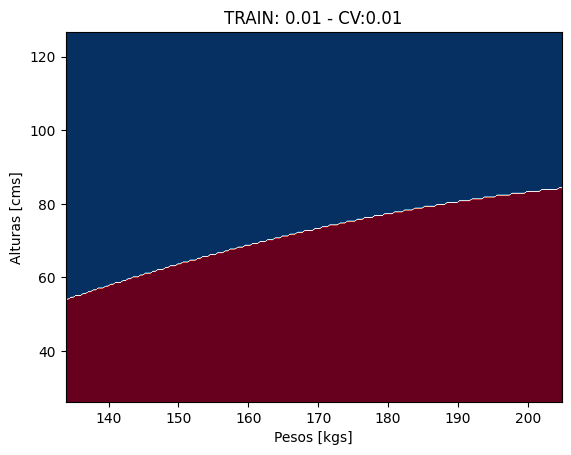

In [90]:
# Crear una malla de valores para altura y peso
x_min, x_max = data["Altura"].min() - 5, data["Altura"].max() + 5
y_min, y_max = data["Peso"].min() - 5, data["Peso"].max() + 5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))

# Transformar la malla con la extensión cuadrática
XX = xx.ravel()
YY = yy.ravel()
XX_sq = XX**2
YY_sq = YY**2
XY = XX * YY

X_grid = np.vstack([YY, YY_sq, XX, XX_sq, XY]).T  # (peso, peso², altura, altura², peso*altura)

# Predecir con el modelo LDA entrenado
Z = lda_quad.predict(X_grid)
# Convert string predictions to numerical values
Z = [1 if z == 'Hombre' else 0 for z in Z] # Assuming 'Hombre' is 0 and 'Mujer' is 1. Adjust if needed
Z = np.array(Z).reshape(xx.shape)


# Graficar la frontera de decisión
plt.contourf(xx, yy, Z, 256, vmin=0., vmax=1., cmap=cm) #Changed ax.contourf to plt.contourf as ax is not defined in the provided code.
plt.title('TRAIN: ' + str(np.round(train_acc)/100) + ' - CV:' + str(np.round(test_acc)/100))
plt.ylabel('Alturas [cms]')
plt.xlabel('Pesos [kgs]')
plt.show()

El umbral de decisión sigue siendo lineal? No, ahora es una curva cuadratica.

Cuántos parámetros tiene el modelo ahora? Tiene 5 parametros aparte de la interseccion.

Cuántos parámetros tenía antes? 2 parametros.

Cómo dan las métricas de train y validación? Aunque mantienen valores altos de accuracy, esta disminuye en comparacion al modelo lineal.

In [92]:
from sklearn.linear_model import LogisticRegression

X = data[["Altura", "Peso"]].values
y = data["Genero"].values

# Definir el modelo de Regresión Logística con C=1e12
log_reg = LogisticRegression(C=1e12)

# Entrenar el modelo con los datos originales (Altura y Peso)
log_reg.fit(X, y)

# Predicción de prueba
y_pred_log = log_reg.predict(X)

# Precisión del modelo
accuracy_log = accuracy_score(y, y_pred_log)
print(f"Precisión del modelo de Regresión Logística: {accuracy_log:.4f}")

Precisión del modelo de Regresión Logística: 0.9166


In [97]:
from sklearn.metrics import accuracy_score, classification_report

# Precisión del modelo
accuracy_log = accuracy_score(y, y_pred_log)
print(f"Precisión del modelo de Regresión Logística: {accuracy_log:.4f}")

# Reporte de métricas
print("Reporte de clasificación:")
print(classification_report(y, y_pred_log))

Precisión del modelo de Regresión Logística: 0.9166
Reporte de clasificación:
              precision    recall  f1-score   support

      Hombre       0.92      0.92      0.92      4002
       Mujer       0.92      0.92      0.92      3998

    accuracy                           0.92      8000
   macro avg       0.92      0.92      0.92      8000
weighted avg       0.92      0.92      0.92      8000

